# Mobility Analytics

goals of the tutorial

- transform movement data into information
- trajectory
(- map matching )

based on the data of Strava 

requirements
- python knowledge
- geopandas
- GPX format

status<br/>
“Where's Wally?”
{: .notice--success}

---


# GNSS
 
 Global Navigation Satellite System (GNSS) refers to a constellation of satellites providing signals from space that transmit positioning and timing data to GNSS receivers. The receivers then use this data to determine location. By definition, GNSS provides global coverage.

## basic
![](https://ardupilot.org/copter/_images/ag_GPS_Operation_New_low_res.jpg)

## with corrections
![](https://freesvg.org/img/GPS_differentialCorrection.png)




---

# GPX Format
GPX, or GPS Exchange Format, is an XML schema designed as a common GPS data format for software applications. It can be used to describe waypoints, tracks, and routes.

## units
### position
latitude and longitude are expressed in **decimal degrees**, and **elevation in meters**, both using the **WGS 84 datum** (epsg 4326).
### time
dates and times are not local time, but instead are Coordinated Universal Time (UTC) using ISO 8601 format (YYYY-MM-DDTHH:MM:SSZ)


## data 

![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Wayroutrackp.png)

(image by [Berklas](https://commons.wikimedia.org/w/index.php?title=User:Berklas) distributed under cc-by-sa 3.0)

- **wptType** is an individual waypoint among a collection of points with no sequential relationship. It consists of the WGS 84 (GPS) coordinates of a point and possibly other descriptive information.
- **rteType** is a route, an ordered list of routepoint (waypoints representing a series of significant turn or stage points) leading to a destination.
- **trkType** is a track, made of at least one segment containing waypoints, that is, an ordered list of points describing a path. A Track Segment holds a list of Track Points which are logically connected in order. To represent a single GPS track where GPS reception was lost, or the GPS receiver was turned off, start a new Track Segment for each continuous span of track data.


details about the format on fhe officiale [website](https://www.topografix.com/gpx.asp)


```xml
<?xml version="1.0" encoding="UTF-8" standalone="no" ?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxx="http://www.garmin.com/xmlschemas/GpxExtensions/v3" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" creator="Oregon 400t" version="1.1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/GpxExtensions/v3 http://www.garmin.com/xmlschemas/GpxExtensionsv3.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd">
  <metadata>
    <link href="http://www.garmin.com">
      <text>Garmin International</text>
    </link>
    <time>2009-10-17T22:58:43Z</time>
  </metadata>
  <trk>
    <name>Example GPX Document</name>
    <trkseg>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>4.46</ele>
        <time>2009-10-17T18:37:26Z</time>
      </trkpt>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>4.94</ele>
        <time>2009-10-17T18:37:31Z</time>
      </trkpt>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>6.87</ele>
        <time>2009-10-17T18:37:34Z</time>
      </trkpt>
    </trkseg>
  </trk>
</gpx>
```

information from [wikipedia](https://en.wikipedia.org/wiki/GPS_Exchange_Format)

---

# Commmon problems 

Missing Data
- Temporal gaps
- Spatial gaps

Incorrect data:
- location or time is incorrect in the data frame

Outliers:
- Too fast movements
- Incorrect order of temporal information 

---

# Setup

In [222]:
!pip install gpxpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!pip install movingpandas

In [224]:
import gpxpy
import urllib.request
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from datetime import datetime,timezone, timedelta

import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS #libreria necessaria per riproiettare le coordinate
from shapely.ops import split #usato per dividere una geometria in più geometrie
import warnings
warnings.filterwarnings('ignore') #inserito solo per eliminare i messaggi di warning su alcune questioni di funzioni che saranno deprecate in futuro

# Let's start to play with GPX files

## Download the data


![](https://github.com/napo/geospatial_course_unitn/blob/master/images/strava_clean.jpg?raw=true)

If you are registered and the author permits the download you can download the gps track but and investigate with [GPX Studio](https://gpx.studio) **without timestamps**


![gpx-strava.png](https://i.postimg.cc/x8mMQL9C/gpx-strava.png)] 

[download file](https://gist.github.com/napo/2aa15957b687dd676d448888619bd39f)

or ... you can use [Strava To Gpx](https://mapstogpx.com/strava/) 


![gpx-full.png](https://i.postimg.cc/yNrLYXCX/gpx-full.png)]

[download file](https://gist.github.com/napo/4d0c14585da0ef96f263faa0e8d97ff5)


## investigate the file  

In [225]:
gpx_url = "https://gist.githubusercontent.com/napo/4d0c14585da0ef96f263faa0e8d97ff5/raw/efba18f806459b462a1e485023cdd01c4d20e01a/strava_full.gpx"
gpx_file = "strava_full.gpx"


urllib.request.urlretrieve(gpx_url,gpx_file)
gpx_file = open(gpx_file, 'r')
gpx = gpxpy.parse(gpx_file)

In [226]:
gpx.creator

'https://www.mapstogpx.com/strava'

In [227]:
len(gpx.tracks)

1

In [228]:
len(gpx.tracks[0].segments)

1

In [229]:
segment = gpx.tracks[0].segments[0]

In [230]:
segment

GPXTrackSegment(points=[...])

In [231]:
segment.points

[GPXTrackPoint(45.900222, 10.847826, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 38, tzinfo=SimpleTZ("Z")), name='TP00001'),
 GPXTrackPoint(45.900264, 10.84785, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 39, tzinfo=SimpleTZ("Z")), name='TP00002'),
 GPXTrackPoint(45.900125, 10.847843, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 40, tzinfo=SimpleTZ("Z")), name='TP00003'),
 GPXTrackPoint(45.89989, 10.847836, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 41, tzinfo=SimpleTZ("Z")), name='TP00004'),
 GPXTrackPoint(45.899786, 10.847835, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 42, tzinfo=SimpleTZ("Z")), name='TP00005'),
 GPXTrackPoint(45.899773, 10.847798, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 44, tzinfo=SimpleTZ("Z")), name='TP00006'),
 GPXTrackPoint(45.899764, 10.847751, elevation=96.5, time=datetime.datetime(2021, 10, 12, 12, 1, 54, tzinfo=SimpleTZ("Z")), name='TP00007'),
 GPXTrackPoint(

In [232]:
segment.points[0].latitude

45.900222

In [233]:
segment.points[0].longitude

10.847826

In [234]:
segment.points[0].elevation

96.5

## creation of a pandas DataFrame

In [235]:
data = []
for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                point.elevation, point.time]) 

columns = ['longitude', 'latitude', 'altitude', 'time'] 
gpx_tracks = pd.DataFrame(data, columns=columns)
# Strava to GPX assign the date of the download of the file as timestamp and SimpleTZ("Z") as TimeZone.
# we can remove it
gpx_tracks['time'] = gpx_tracks['time'].apply(lambda x: x.replace(tzinfo=None))

# index creation needed by MovingPandas
df = gpx_tracks.set_index('time')

travel time

In [236]:
start_point = data[0]
end_point = data[-1]

In [237]:
# travel time
# funzione che calcola la differenza
travel_time = end_point[3]-start_point[3]
travel_time_seconds = timedelta(seconds=travel_time.total_seconds())
travel_time_hours = str(timedelta(seconds=travel_time_seconds.seconds))
print_travel_time = travel_time_hours.split(':')
print("travel time %sh %s' %s''" % (print_travel_time[0], print_travel_time[1], print_travel_time[2]))

travel time 2h 34' 41''


## reverse geocoding

In [238]:
from geopy.geocoders import Nominatim 

latlon = str(start_point[1]) + "," + str(start_point[0])
geolocator = Nominatim(user_agent="geospatial course unitn")
starting_place = geolocator.reverse(latlon)

In [239]:
starting_place

Location(Via Luigi Pigarelli, Fangolino, Gavazzo, Varone, Comunità Alto Garda e Ledro, Provincia di Trento, Trentino-Alto Adige/Südtirol, 38066, Italia, (45.899909740397625, 10.847610675042551, 0.0))

In [240]:
latlon = str(end_point[1]) + "," + str(end_point[0])
geolocator = Nominatim(user_agent="geospatial course unitn")
arrival_place = geolocator.reverse(latlon)

In [241]:
arrival_place

Location(Pronto Soccorso Ospedale di Arco, Viale dei Capitelli, Chiarano, Varignano, Arco, Comunità Alto Garda e Ledro, Provincia di Trento, Trentino-Alto Adige/Südtirol, 38062, Italia, (45.919077, 10.875114, 0.0))

##  Analyzing trajectories


In [242]:
# GeoDataFrame for MovingPandas
geo_df = gpd.GeoDataFrame(df, 
crs=4326,
geometry= gpd.points_from_xy(df.longitude, df.latitude, df.altitude))

In [243]:
# creazione dell'oggetto delle traiettore attraverso Movingpandas
trajectory = mpd.Trajectory(geo_df, 1)

<AxesSubplot:>

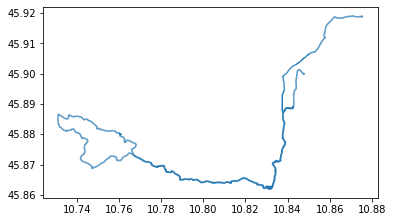

In [244]:
trajectory.plot()

In [245]:
trajectory.hvplot(geo=True, tiles='OSM', line_width=5) #, frame_width=300, frame_height=300)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]

In [246]:
trajectory.add_speed(overwrite=True)
trajectory.df

longitude   latitude  altitude  \
time                                                  
2021-10-12 12:01:38  10.847826  45.900222      96.5   
2021-10-12 12:01:39  10.847850  45.900264      96.5   
2021-10-12 12:01:40  10.847843  45.900125      96.5   
2021-10-12 12:01:41  10.847836  45.899890      96.5   
2021-10-12 12:01:42  10.847835  45.899786      96.5   
...                        ...        ...       ...   
2021-10-12 14:34:13  10.875184  45.919097      91.6   
2021-10-12 14:34:20  10.875213  45.919122      91.6   
2021-10-12 14:34:30  10.875186  45.919142      91.6   
2021-10-12 14:35:45  10.875151  45.919126      91.6   
2021-10-12 14:36:19  10.875091  45.919049      91.6   

                                                 geometry      speed  
time                                                                  
2021-10-12 12:01:38  POINT Z (10.84783 45.90022 96.50000)   5.026084  
2021-10-12 12:01:39  POINT Z (10.84785 45.90026 96.50000)   5.026084  
2021-10-12 12:01:40  POINT Z (10.84784 45.90013 96.50000)  15.459309  
2021-10-12 12:01:41  POINT Z (10.84784 45.89989 96.50000)  26.125749  
2021-10-12 12:01:42  POINT Z (10.84783 45.89979 96.50000)  11.559794  
...                                                   ...        ...  
2021-10-12 14:34:13  POINT Z (10.87518 45.91910 91.60000)   0.765202  
2021-10-12 14:34:20  POINT Z (10.87521 45.91912 91.60000)   0.510754  
2021-10-12 14:34:30  POINT Z (10.87519 45.91914 91.60000)   0.305432  
2021-10-12 14:35:45  POINT Z (10.87515 45.91913 91.60000)   0.043276  
2021-10-12 14:36:19  POINT Z (10.87509 45.91905 91.60000)   0.286540  

[5532 rows x 5 columns]

In [247]:
# convdersion m/s to km/h
def ms_to_km(ms):
    v = (ms) * (60*60)/1000
    return v

In [248]:
# km/h column
trajectory.df['kmh'] = trajectory.df['speed'].apply(ms_to_km)

<AxesSubplot:>

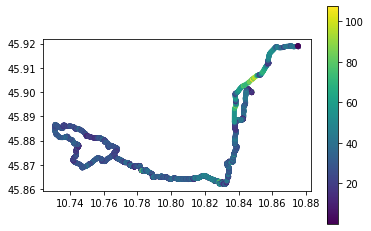

In [249]:
trajectory.plot(column="kmh", linewidth=5, capstyle='round', legend=True)

## Extracting a moving object's position was at a certain time 

In [250]:
trajectory

Trajectory 1 (2021-10-12 12:01:38 to 2021-10-12 14:36:19) | Size: 5532 | Length: 40316.6m
Bounds: (10.731099, 45.861882, 10.875513, 45.919142)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836

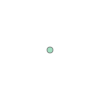

In [251]:
trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest")

In [252]:
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest"))

POINT Z (10.840998 45.888594 81.09999999999999)


In [253]:
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest"))
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="interpolated"))
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="ffill")) # from the previous row
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="bfill")) # from the following row

POINT Z (10.840998 45.888594 81.09999999999999)
POINT Z (10.840998 45.888594 81.09999999999999)
POINT Z (10.840998 45.888594 81.09999999999999)
POINT Z (10.840998 45.888594 81.09999999999999)


## Extracting trajectory segments based on time

In [254]:
segment_clip = trajectory.get_segment_between(datetime(2021,10,12,13,36,1),datetime(2021,10,12,13,38,51))
print(segment_clip)

Trajectory 1_2021-10-12 13:36:01 (2021-10-12 13:36:01 to 2021-10-12 13:38:49) | Size: 158 | Length: 1457.3m
Bounds: (10.832986, 45.870462, 10.839058, 45.879066)
LINESTRING Z (10.832986 45.870462 160.3, 10.833045 45.870534 159.9, 10.83311 45.870598 159.5, 10.833


<AxesSubplot:>

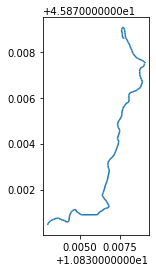

In [255]:
segment_clip.plot()

## Extracting trajectory segments based on  geometry (i.e. clipping)

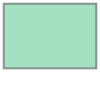

In [256]:
from shapely.geometry import Point, Polygon
latitude=45.88880
longitude=10.84269
p = Point(longitude, latitude)
point = gpd.GeoDataFrame(pd.DataFrame(), 
    crs=4326,
    geometry= [p])
distance = 10 # meters
# create a bounding box
xmin, ymax, xmax, ymin = point.to_crs(epsg=32632).buffer(distance).geometry.to_crs(epsg=4326).iloc[0].bounds
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
polygon


In [257]:
intersections = trajectory.clip(polygon)
intersections

TrajectoryCollection with 3 trajectories

<AxesSubplot:>

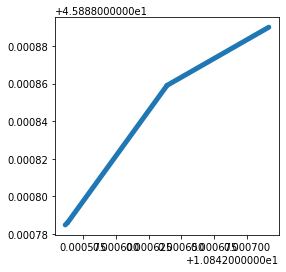

In [258]:
intersections.trajectories[0].plot(linewidth=5, capstyle='round')

<AxesSubplot:>

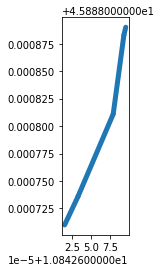

In [259]:
intersections.trajectories[1].plot(linewidth=5, capstyle='round')

<AxesSubplot:>

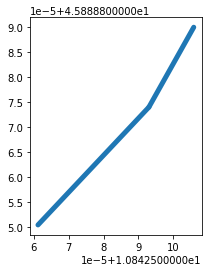

In [260]:
intersections.trajectories[2].plot(linewidth=5, capstyle='round')

## Splitting trajectories 

Gaps are quite common in trajectories. For example, GPS tracks may contain gaps if moving objects enter tunnels where GPS reception is lost. In other use cases, moving objects may leave the observation area for longer time before returning and continuing their recorded track.

Depending on the use case, we therefore might want to split trajectories at observation gaps that exceed a certain minimum duration:

### duration 15 minutes

In [261]:
split = mpd.ObservationGapSplitter(trajectory).split(gap=timedelta(minutes=15))
for traj in split:
    print(traj)

Trajectory 1_0 (2021-10-12 12:01:38 to 2021-10-12 13:47:11) | Size: 5070 | Length: 34131.1m
Bounds: (10.731099, 45.861882, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2 (2021-10-12 14:24:10 to 2021-10-12 14:36:19) | Size: 461 | Length: 6182.5m
Bounds: (10.837456, 45.887391, 10.875513, 45.919142)
LINESTRING Z (10.842638 45.888938 79.40000000000001, 10.842624 45.888947 79.5, 10.842587 45.888957 7


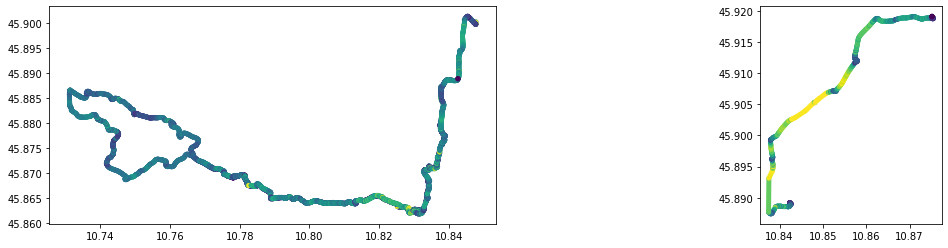

In [262]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

## 1km

In [220]:
split = mpd.StopSplitter(trajectory).split(min_duration=timedelta(minutes=15), max_diameter=30, min_length=1000)
for traj in split:
    print(traj)

Trajectory 1_2021-10-12 12:01:38 (2021-10-12 12:01:38 to 2021-10-12 13:47:11) | Size: 5070 | Length: 34131.1m
Bounds: (10.731099, 45.861882, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2021-10-12 14:24:50 (2021-10-12 14:24:50 to 2021-10-12 14:36:19) | Size: 449 | Length: 6131.0m
Bounds: (10.837456, 45.887391, 10.875513, 45.919142)
LINESTRING Z (10.842435 45.889193 81.09999999999999, 10.842394 45.889205 81.2, 10.842355 45.889195 8


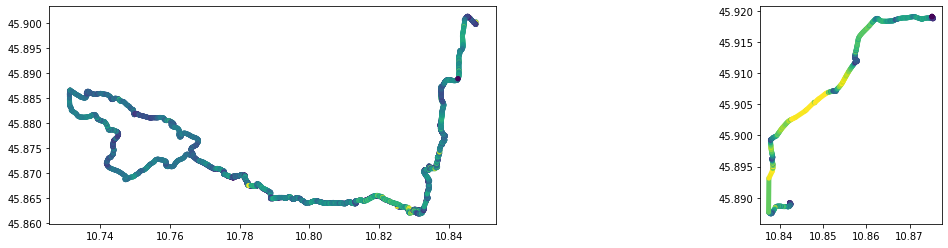

In [221]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

## Stop detection

In [263]:
detector = mpd.TrajectoryStopDetector(trajectory)

In [264]:
traj_plot = trajectory.hvplot(title='Trajectory {}'.format(trajectory.id), line_width=7.0, tiles='CartoLight', color='slategray', frame_width=350, frame_height=350) 
traj_plot

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]

### stop duration

In [265]:
%%time
stop_durations = detector.get_stop_time_ranges(min_duration=timedelta(seconds=60), max_diameter=100)

In [ ]:
for x in stop_durations: 
    print(x)

Traj 1: 2021-10-12 12:40:59 - 2021-10-12 12:41:59 (duration: 0 days 00:01:00)
Traj 1: 2021-10-12 12:45:28 - 2021-10-12 12:46:40 (duration: 0 days 00:01:12)
Traj 1: 2021-10-12 12:46:44 - 2021-10-12 12:47:51 (duration: 0 days 00:01:07)
Traj 1: 2021-10-12 12:47:56 - 2021-10-12 12:49:26 (duration: 0 days 00:01:30)
Traj 1: 2021-10-12 12:50:03 - 2021-10-12 12:51:04 (duration: 0 days 00:01:01)
Traj 1: 2021-10-12 12:51:09 - 2021-10-12 12:52:47 (duration: 0 days 00:01:38)
Traj 1: 2021-10-12 13:41:59 - 2021-10-12 14:25:49 (duration: 0 days 00:43:50)
Traj 1: 2021-10-12 14:34:30 - 2021-10-12 14:36:19 (duration: 0 days 00:01:49)


## stop points

In [ ]:
%%time
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 18.2 s, sys: 7.97 ms, total: 18.2 s
Wall time: 18.3 s


In [ ]:
stop_points

geometry  \
stop_id                                                        
1_2021-10-12 12:40:59  POINT Z (10.78989 45.86505 462.90000)   
1_2021-10-12 12:45:28  POINT Z (10.78315 45.86742 518.50000)   
1_2021-10-12 12:46:44  POINT Z (10.78217 45.86820 533.70000)   
1_2021-10-12 12:47:56  POINT Z (10.78158 45.86913 550.40000)   
1_2021-10-12 12:50:03  POINT Z (10.77957 45.86942 579.00000)   
1_2021-10-12 12:51:09  POINT Z (10.77831 45.86930 592.90000)   
1_2021-10-12 13:41:59   POINT Z (10.84269 45.88890 79.40000)   
1_2021-10-12 14:34:30   POINT Z (10.87519 45.91914 91.60000)   

                               start_time            end_time  traj_id  \
stop_id                                                                  
1_2021-10-12 12:40:59 2021-10-12 12:40:59 2021-10-12 12:41:59        1   
1_2021-10-12 12:45:28 2021-10-12 12:45:28 2021-10-12 12:46:40        1   
1_2021-10-12 12:46:44 2021-10-12 12:46:44 2021-10-12 12:47:51        1   
1_2021-10-12 12:47:56 2021-10-12 12:47:56 2021-10-12 12:49:26        1   
1_2021-10-12 12:50:03 2021-10-12 12:50:03 2021-10-12 12:51:04        1   
1_2021-10-12 12:51:09 2021-10-12 12:51:09 2021-10-12 12:52:47        1   
1_2021-10-12 13:41:59 2021-10-12 13:41:59 2021-10-12 14:25:49        1   
1_2021-10-12 14:34:30 2021-10-12 14:34:30 2021-10-12 14:36:19        1   

                       duration_s  
stop_id                            
1_2021-10-12 12:40:59        60.0  
1_2021-10-12 12:45:28        72.0  
1_2021-10-12 12:46:44        67.0  
1_2021-10-12 12:47:56        90.0  
1_2021-10-12 12:50:03        61.0  
1_2021-10-12 12:51:09        98.0  
1_2021-10-12 13:41:59      2630.0  
1_2021-10-12 14:34:30       109.0

In [ ]:
stop_point_plot = traj_plot * stop_points.hvplot(geo=True, size='duration_s', color='deeppink')
stop_point_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (duration_s)

## stop segments

In [ ]:
%%time
stops = detector.get_stop_segments(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 16.4 s, sys: 11.9 ms, total: 16.4 s
Wall time: 16.5 s


In [ ]:
stops

TrajectoryCollection with 8 trajectories

In [ ]:
stop_segment_plot = stop_point_plot * stops.hvplot( size=200, line_width=7.0, tiles=None, color='orange') 
stop_segment_plot

:Overlay
   .Tiles.I   :Tiles   [x,y]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (duration_s)
   .Path.II   :Path   [Longitude,Latitude]
   .Path.III  :Path   [Longitude,Latitude]
   .Path.IV   :Path   [Longitude,Latitude]
   .Path.V    :Path   [Longitude,Latitude]
   .Path.VI   :Path   [Longitude,Latitude]
   .Path.VII  :Path   [Longitude,Latitude]
   .Path.VIII :Path   [Longitude,Latitude]
   .Path.IX   :Path   [Longitude,Latitude]

## split a stop

In [ ]:
%%time
split = mpd.StopSplitter(trajectory).split(min_duration=timedelta(seconds=60), max_diameter=100)


CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.1 s


In [ ]:
split

TrajectoryCollection with 8 trajectories

In [ ]:
for segment in split:
    print(segment)


Trajectory 1_2021-10-12 12:01:38 (2021-10-12 12:01:38 to 2021-10-12 12:40:59) | Size: 1859 | Length: 10497.8m
Bounds: (10.789892, 45.861981, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2021-10-12 12:41:59 (2021-10-12 12:41:59 to 2021-10-12 12:45:28) | Size: 150 | Length: 647.8m
Bounds: (10.78315, 45.865551, 10.788879, 45.867858)
LINESTRING Z (10.788848 45.865551 478.6, 10.788839 45.865583 478.8, 10.788834 45.865623 479.1, 10.78
Trajectory 1_2021-10-12 12:46:40 (2021-10-12 12:46:40 to 2021-10-12 12:46:44) | Size: 3 | Length: 8.3m
Bounds: (10.782169, 45.868145, 10.782239, 45.868201)
LINESTRING Z (10.782239 45.868145 533, 10.782199 45.868181 533.4, 10.782169 45.868201 533.7)
Trajectory 1_2021-10-12 12:47:51 (2021-10-12 12:47:51 to 2021-10-12 12:47:56) | Size: 3 | Length: 8.5m
Bounds: (10.781579, 45.869051, 10.781585, 45.869127)
LINESTRING Z (10.781579 45.869051 549, 10.781585 45.869089 549.7, 10.781

## Generalizing trajectories 

### Douglas-Peucker algorithm

<AxesSubplot:>

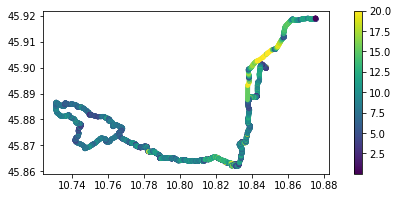

In [ ]:
trajectory.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)



<AxesSubplot:>

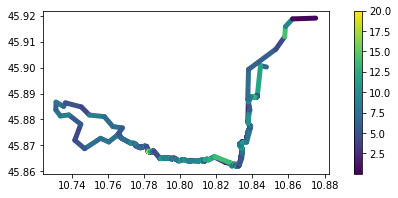

In [ ]:
generalized_trajectory = mpd.DouglasPeuckerGeneralizer(trajectory).generalize(tolerance=0.001)
generalized_trajectory.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)

In [ ]:
print('Original length: %s'%(trajectory.get_length()))
print('Generalized length: %s'%(generalized_trajectory.get_length()))

Original length: 40316.62984539696
Generalized length: 37390.63448916238


###  alternative down-sample the trajectory to ensure a certain time delta between records

<AxesSubplot:>

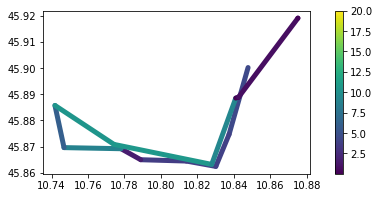

In [ ]:
time_generalized = mpd.MinTimeDeltaGeneralizer(trajectory).generalize(tolerance=timedelta(minutes=10))
time_generalized.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)


In [ ]:
time_generalized.to_point_gdf().head(10)

longitude   latitude  altitude  \
time                                                  
2021-10-12 12:01:38  10.847826  45.900222      96.5   
2021-10-12 12:11:38  10.837393  45.874687     118.6   
2021-10-12 12:21:38  10.830129  45.862466     244.0   
2021-10-12 12:31:38  10.813936  45.864505     371.3   
2021-10-12 12:41:38  10.788925  45.865013     477.9   
2021-10-12 12:51:39  10.778118  45.869216     598.4   
2021-10-12 13:01:39  10.746818  45.869637     657.8   
2021-10-12 13:11:39  10.741853  45.885748     656.5   
2021-10-12 13:21:39  10.774246  45.870862     637.8   
2021-10-12 13:31:39  10.827858  45.863224     301.4   

                                                  geometry      speed  \
time                                                                    
2021-10-12 12:01:38   POINT Z (10.84783 45.90022 96.50000)   5.026084   
2021-10-12 12:11:38  POINT Z (10.83739 45.87469 118.60000)   4.446633   
2021-10-12 12:21:38  POINT Z (10.83013 45.86247 244.00000)   3.863094   
2021-10-12 12:31:38  POINT Z (10.81394 45.86451 371.30000)   3.815148   
2021-10-12 12:41:38  POINT Z (10.78893 45.86501 477.90000)   3.525257   
2021-10-12 12:51:39  POINT Z (10.77812 45.86922 598.40000)   1.619121   
2021-10-12 13:01:39  POINT Z (10.74682 45.86964 657.80000)   8.849716   
2021-10-12 13:11:39  POINT Z (10.74185 45.88575 656.50000)   6.003111   
2021-10-12 13:21:39  POINT Z (10.77425 45.87086 637.80000)  10.406578   
2021-10-12 13:31:39  POINT Z (10.82786 45.86322 301.40000)  10.652206   

                           kmh  
time                            
2021-10-12 12:01:38  18.093904  
2021-10-12 12:11:38  16.007878  
2021-10-12 12:21:38  13.907137  
2021-10-12 12:31:38  13.734534  
2021-10-12 12:41:38  12.690925  
2021-10-12 12:51:39   5.828837  
2021-10-12 13:01:39  31.858976  
2021-10-12 13:11:39  21.611198  
2021-10-12 13:21:39  37.463682  
2021-10-12 13:31:39  38.347942

In [ ]:
trajectory.to_point_gdf().head(10)

longitude   latitude  altitude  \
time                                                  
2021-10-12 12:01:38  10.847826  45.900222      96.5   
2021-10-12 12:01:39  10.847850  45.900264      96.5   
2021-10-12 12:01:40  10.847843  45.900125      96.5   
2021-10-12 12:01:41  10.847836  45.899890      96.5   
2021-10-12 12:01:42  10.847835  45.899786      96.5   
2021-10-12 12:01:44  10.847798  45.899773      96.5   
2021-10-12 12:01:54  10.847751  45.899764      96.5   
2021-10-12 12:01:56  10.847786  45.899790      96.5   
2021-10-12 12:01:57  10.847749  45.899800      96.5   
2021-10-12 12:02:01  10.847702  45.899803      96.5   

                                                 geometry      speed  \
time                                                                   
2021-10-12 12:01:38  POINT Z (10.84783 45.90022 96.50000)   5.026084   
2021-10-12 12:01:39  POINT Z (10.84785 45.90026 96.50000)   5.026084   
2021-10-12 12:01:40  POINT Z (10.84784 45.90013 96.50000)  15.459309   
2021-10-12 12:01:41  POINT Z (10.84784 45.89989 96.50000)  26.125749   
2021-10-12 12:01:42  POINT Z (10.84783 45.89979 96.50000)  11.559794   
2021-10-12 12:01:44  POINT Z (10.84780 45.89977 96.50000)   1.607194   
2021-10-12 12:01:54  POINT Z (10.84775 45.89976 96.50000)   0.378204   
2021-10-12 12:01:56  POINT Z (10.84779 45.89979 96.50000)   1.982969   
2021-10-12 12:01:57  POINT Z (10.84775 45.89980 96.50000)   3.078936   
2021-10-12 12:02:01  POINT Z (10.84770 45.89980 96.50000)   0.915638   

                           kmh  
time                            
2021-10-12 12:01:38  18.093904  
2021-10-12 12:01:39  18.093904  
2021-10-12 12:01:40  55.653513  
2021-10-12 12:01:41  94.052696  
2021-10-12 12:01:42  41.615259  
2021-10-12 12:01:44   5.785899  
2021-10-12 12:01:54   1.361533  
2021-10-12 12:01:56   7.138687  
2021-10-12 12:01:57  11.084170  
2021-10-12 12:02:01   3.296297